In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [72]:
class Deconv2D(nn.Module):
    def __init__(self, size: int=3):
        super(Deconv2D, self).__init__()
        assert type(size) == int
        w = torch.zeros(size, size)
        w[size//2, size//2] = 1
        self.w= nn.Parameter(data=w,
                             requires_grad=True)
        print(self.w)
        self.h_shape = (size, size)

    def forward(self, x):
        # w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = self.w
        
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        # gm2f = torch.flip(gm1f, (0,))
        # gm2f = torch.roll(gm1f, shifts=1, dims=0)

        # gm3f = torch.flip(gm1f, (1,))
        # gm3f = torch.roll(gm1f, shifts=1, dims=1)

        # gm4f = torch.flip(gm1f, (0, 1))
        # gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        # gmf = gm1f*gm2f*gm3f*gm4f
        gmf = gm1f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

In [73]:
Deconv2D(3)

Parameter containing:
tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]], requires_grad=True)


Deconv2D()

In [74]:
import numpy as np

def gaussian_kernel(kernel_size, sigma=1):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    for x in range(0, kernel_size):
        for y in range(0, kernel_size):
            x_val = x - center
            y_val = y - center
            kernel[x, y] = np.exp(-(x_val ** 2 + y_val ** 2) / (2 * (sigma ** 2)))

    return kernel / np.sum(kernel)


def blur_images(img, size=5):

    # 4 factor blur
    w = torch.tensor(gaussian_kernel(size), dtype=torch.float32)

    hm1 = nn.functional.pad(w, (0, img.size(-1)-w.size(-1), 0, img.size(-2)-w.size(-2)))

    gm1f = fft2(hm1)

    gmf = gm1f

    ymf = gmf*fft2(img)

    X = ifft2(ymf).real

    return X

In [75]:
gaussian_kernel(3)

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

In [76]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/data/DIV2K/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
class GoproSynthetic(Dataset):
    def __init__(self, ds_path):
        self.ds_path = ds_path

        y_imgs = os.listdir(f'{ds_path}/LR_bicubic_X2')[:20]

        self.y_paths = list(map(lambda img_path: f'{ds_path}/LR_bicubic_X2/{img_path}', y_imgs))

    
    def __len__(self):
        return len(self.y_paths)


    def __getitem__(self, idx):
        y_path = self.y_paths[idx]

        # x_img = io.read_image(x_path, io.ImageReadMode.GRAY)
        y_img = io.read_image(y_path, io.ImageReadMode.GRAY)

        SIZE = 128
        PAD_SIZE = SIZE//4

        # Preprocess image
        y_img = T.Resize((SIZE, SIZE))(y_img)
        y_img = y_img / 255.0
        y_img = nn.functional.pad(y_img, (PAD_SIZE, PAD_SIZE, PAD_SIZE, PAD_SIZE))

        # Preprocess image
        x_img = blur_images(y_img)

        return x_img, y_img

In [78]:
data = GoproSynthetic(ds_path=base_path)

data_len = len(data)
dataloader = DataLoader(data, batch_size=16, shuffle=False)

data_len

20

(-0.5, 191.5, 191.5, -0.5)

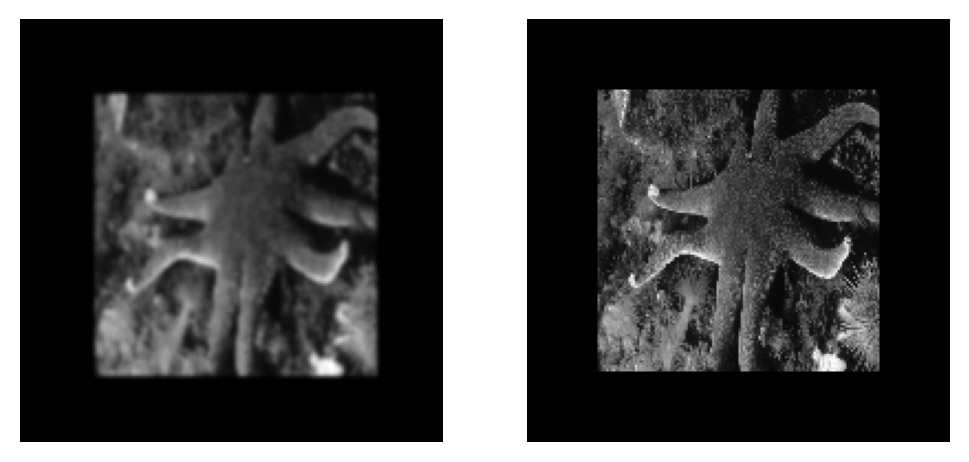

In [79]:
blur_img, unblur_img = next(iter(dataloader))

plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.imshow(blur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(unblur_img[0, 0, :, :],cmap='gray')
plt.axis('off')

In [98]:
model = Deconv2D(5)

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)


In [104]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss= 0.0

        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = criterion(outputs, y)

                symmetry_penalty = torch.norm(model.w - torch.flip(model.w, (0,))) ** 2
                symmetry_penalty += torch.norm(model.w - torch.flip(model.w, (1,))) ** 2
                symmetry_penalty += torch.norm(model.w - torch.flip(model.w, (0, 1))) ** 2
                loss = loss + symmetry_penalty

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss

        if (epoch+1)%50 == 0:
            print('Epoch {:04d} loss: {:.5f}'.format(epoch+1, running_loss))

In [105]:
train_model(model, criterion, optimizer, dataloader, num_epochs=1000)

Epoch 0050 loss: 0.00549
Epoch 0100 loss: 0.00547
Epoch 0150 loss: 0.00546
Epoch 0200 loss: 0.00545
Epoch 0250 loss: 0.00545
Epoch 0300 loss: 0.00544
Epoch 0350 loss: 0.00543
Epoch 0400 loss: 0.00543
Epoch 0450 loss: 0.00542
Epoch 0500 loss: 0.00541
Epoch 0550 loss: 0.00541
Epoch 0600 loss: 0.00540
Epoch 0650 loss: 0.00540
Epoch 0700 loss: 0.00539
Epoch 0750 loss: 0.00538
Epoch 0800 loss: 0.00538
Epoch 0850 loss: 0.00537
Epoch 0900 loss: 0.00536
Epoch 0950 loss: 0.00535
Epoch 1000 loss: 0.00535


Text(0.5, 1.0, 'Original')

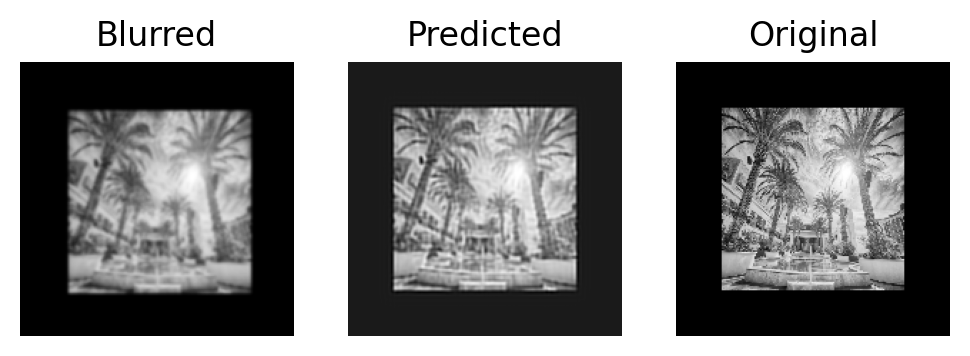

In [106]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

In [107]:
model.w

Parameter containing:
tensor([[-0.0229,  0.1047, -0.0421,  0.1047, -0.0229],
        [ 0.0781,  0.0430, -0.1332,  0.0430,  0.0781],
        [-0.0125, -0.1188,  0.8055, -0.1188, -0.0125],
        [ 0.0781,  0.0430, -0.1332,  0.0430,  0.0781],
        [-0.0229,  0.1047, -0.0421,  0.1047, -0.0229]], requires_grad=True)